In [1]:
cd ~/PycharmProjects/CleanSpace/momia2/

/Users/jzrolling/PycharmProjects/CleanSpace/momia2


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt,pickle as pk
import os, glob
from skimage import filters
import momia2 as mo
from microfilm.microplot import microshow
import seaborn as sns

In [7]:
pickle_dict = {}
"""
for f in sorted(glob.glob('/Volumes/ExtremePro/BacProtac_analysis/20231018_microscopy_analysis/*.pk')):
    #if 'F05' in f:
    s,_r = f.split('/')[-1].split('RAPA')
    s = s[:-1]
    rapa = _r[0]
    header = _r.split('.')[0].split('_')[1]
    if s not in pickle_dict:
        pickle_dict[s] = [f]
    else:
        pickle_dict[s].append(f)

for f in sorted(glob.glob('/Volumes/ExtremePro/BacProtac_analysis/20231018_microscopy_analysis/plate5/*.pk')):
    s,_r = f.split('/')[-1].split('RAPA')
    if 'Plate5' not in s:
        s = s[:-1]
    else:
        s = s[7:-1]
    rapa = _r[0]
    header = _r.split('.')[0].split('_')[1]
    if s not in pickle_dict:
        pickle_dict[s] = [f]
    else:
        pickle_dict[s].append(f)
"""
for f in sorted(glob.glob('/Volumes/ExtremePro/BacProtac_analysis/20240105_TPDrec_9hrs_reorganized/*.pk')):
    s,_r = f.split('/')[-1].split('RAPA')
    s = s[:-1]
    rapa = _r[0]
    header = _r.split('.')[0].split('_')[1]
    if s not in pickle_dict:
        pickle_dict[s] = [f]
    else:
        pickle_dict[s].append(f)

#"""
ref = pd.read_excel('/Volumes/ExtremePro/BacProtac_analysis/Flow_well_keys_pub.xlsx')
deg = pd.read_excel('/Volumes/ExtremePro/BacProtac_analysis/Deg_stats_final_pub.xlsx')
wells = []
for x in ref['Sample'].values:
    try:
        nid = int(x[1:])
        w = x[0] + x[1:].zfill(2)
    except:
        w = ref[ref['Sample']==x]['Target_gene'].unique()
        if len(w)>0:
            w = str(w[0])
        else:
            w = 'nan'
    wells.append(w)
ref['Well'] = wells
#"""

In [10]:
merged = []
for k,v in pickle_dict.items():
    cells = []
    for f in v:
        p = mo.momia_IO.pickle_load(f)
        p.find_outline(approximate=True,tolerance=0.9,interp_distance=1,
                       smooth_level=8,
                       level=0.2,dilation=False,erosion=False,
                       use_binary=True)
        p.extract_midlines()
        p.get_intensity_stats()
        p.get_morphology_stats()

        #redefine filter criterion
        p.filter_particles({'length [µm]':(2.5,16),
                            'width_median [µm]':(0.55,0.95),
                            'width_max [µm]':(0.55,1.1),
                            'branched':(-1,0.5)})

        subset = p.regionprops[p.regionprops['$include']==1][[x for x in p.regionprops.columns if '$' not in x]].copy()
        midline_profiles = []
        outline_profiles = []
        for i in subset.index:
            cell = p.get_particle_data(i)
            img = cell['FITC']
            outline = cell['$outline']
            midline = cell['$midlines'][0]
            midline_profiles.append(mo.utils.measure_along_strip(midline,img,width=int(0.5/0.065)+1))
            outline_profiles.append(mo.utils.measure_along_strip(outline,img,width=4))
        subset['UID'] = ['{}_{}'.format(f.split('/')[-1].split('.pk')[0],x) for x in subset.index]
        subset['midline_profiles'] = midline_profiles
        subset['outline_profiles'] = outline_profiles
        subset['Sample'] = k
        if 'RAPA-' in f:
            subset['Rapa'] = '-'
            subset['Sample_key'] = '{}_-'.format(k)
        else:
            subset['Rapa'] = '+'
            subset['Sample_key'] = '{}_+'.format(k)
        merged.append(subset)
    print(k)
merged=pd.concat(merged)
merged=merged.reset_index(drop=True)
pk.dump(merged,open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/single_cell_data/20240117_scData.pk','wb'))

REC_LeuS
REC_MutT4
REC_NusG
REC_RpsD


In [11]:
merged1 = pk.load(open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/single_cell_data/20231130_scData.pk','rb'))
merged2 = pk.load(open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/single_cell_data/20240117_scData.pk','rb'))
merged=pd.concat([merged1,merged2])
#data = pd.read_csv('/Users/jzrolling/Desktop/OMEGA_GUI/notebooks/RNAseq_analysis/ChengTP_revisit/rpkm_Mtb_SampleFil 2.csv').set_index('Unnamed: 0')
#sample = pd.read_excel('/Users/jzrolling/Desktop/OMEGA_GUI/notebooks/RNAseq_analysis/ChengTP_revisit/Sample info 894_Mtb.xlsx').set_index('Run')
ref = pd.read_excel('/Volumes/ExtremePro/BacProtac_analysis/Flow_well_keys_pub.xlsx')
deg = pd.read_excel('/Volumes/ExtremePro/BacProtac_analysis/Deg_stats_final_pub.xlsx')
#pr_corr = pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/ClpP_project/RNA-Protein correlation/Scarlet Shell vs. Olga et al..xlsx',
#                       sheet_name='Sheet4').set_index('Gene')
ref['Well'] = [x[0]+x[1:].zfill(2) if isinstance(x,str) else x for x in ref['Sample'].values]

In [13]:
for s in ['REC_Mmpl3','REC_PyrG','REC_SecA1','REC_RpoB','REC_RbpA','REC_Ffh',
          'REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']:
    subset=merged[merged['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+']
    rapa_minus = subset[subset['Rapa']=='-']
    fig,axes=plt.subplots(figsize=(6,4),ncols=2,gridspec_kw={'wspace':0.05})
    demo_minus = mo.plot.demograph(rapa_minus['midline_profiles'].values[np.argsort(rapa_minus['length [µm]'].values)],
                                  np.sort(rapa_minus['length [µm]'].values),
                                  align='center',smooth_window=1,max_l=10)[0]
    demo_plus = mo.plot.demograph(rapa_plus['midline_profiles'].values[np.argsort(rapa_plus['length [µm]'].values)],
                                  np.sort(rapa_plus['length [µm]'].values),
                                  align='center',smooth_window=1,max_l=10)[0]
    axes[0].imshow(demo_minus,cmap='magma',vmin=np.percentile(subset['FITC_min'],5)*1.2,vmax=np.percentile(subset['FITC_max'],75)*1.2,aspect='auto')
    axes[1].imshow(demo_plus,cmap='magma',vmin=np.percentile(subset['FITC_min'],5)*1.2,vmax=np.percentile(subset['FITC_max'],75)*1.2,aspect='auto')
    axes[0].set_yticks([])
    axes[1].set_yticks([])
    axes[0].set_xticks([0,64,128,192,256])
    axes[1].set_xticks([0,64,128,192,256])
    axes[0].set_xticklabels([6,3,0,3,6],fontname='Arial',fontsize=12)
    axes[1].set_xticklabels([6,3,0,3,6],fontname='Arial',fontsize=12)
    axes[0].text(1.05,-0.1,'Distance from center [µm]',transform = axes[0].transAxes,fontname='Arial',fontsize=14,ha='center',va='top')
    axes[0].text(1.05,1.02,s.split('_')[1],transform = axes[0].transAxes,fontname='Arial',fontsize=14,ha='center',va='bottom')
    axes[0].text(0.02,0.95,'-RAPA',color='w',transform = axes[0].transAxes,
                 fontname='Arial',fontsize=14,ha='left',va='top',weight="bold")
    axes[1].text(0.02,0.95,'+RAPA',color='w',transform = axes[1].transAxes,
                 fontname='Arial',fontsize=14,ha='left',va='top',weight="bold")
    plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_demograph.svg'.format(s),
            bbox_inches='tight',transparent=True)
    plt.close()

In [184]:
rec_subset = []
for s in ['REC_Mmpl3','REC_PyrG','REC_SecA1','REC_RpoB','REC_RbpA','REC_Ffh',
          'REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']:
    subset=merged[merged['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'].copy()
    rapa_minus = subset[subset['Rapa']=='-'].copy()
    fig,axes=plt.subplots(figsize=(6,4),ncols=2,gridspec_kw={'wspace':0.05})
    demo_minus = mo.plot.demograph(rapa_minus['midline_profiles'].values[np.argsort(rapa_minus['length [µm]'].values)],
                                  np.sort(rapa_minus['length [µm]'].values),
                                  align='center',smooth_window=1,max_l=10)[0]
    demo_plus = mo.plot.demograph(rapa_plus['midline_profiles'].values[np.argsort(rapa_plus['length [µm]'].values)],
                                  np.sort(rapa_plus['length [µm]'].values),
                                  align='center',smooth_window=1,max_l=10)[0]
    axes[0].imshow(demo_minus,cmap='magma',vmin=np.percentile(subset['FITC_min'],5)*1.2,vmax=np.percentile(subset['FITC_max'],75)*1.2,aspect='auto')
    axes[1].imshow(demo_plus,cmap='magma',vmin=np.percentile(subset['FITC_min'],5)*1.2,vmax=np.percentile(subset['FITC_max'],75)*1.2,aspect='auto')
    axes[0].set_yticks([])
    axes[1].set_yticks([])
    axes[0].set_xticks([0,64,128,192,256])
    axes[1].set_xticks([0,64,128,192,256])
    axes[0].set_xticklabels([6,3,0,3,6],fontname='Arial',fontsize=12)
    axes[1].set_xticklabels([6,3,0,3,6],fontname='Arial',fontsize=12)
    axes[0].text(1.05,-0.1,'Distance from center [µm]',transform = axes[0].transAxes,fontname='Arial',fontsize=14,ha='center',va='top')
    axes[0].text(1.05,1.02,s.split('_')[1],transform = axes[0].transAxes,fontname='Arial',fontsize=14,ha='center',va='bottom')
    axes[0].text(0.02,0.95,'-RAPA',color='w',transform = axes[0].transAxes,
                 fontname='Arial',fontsize=14,ha='left',va='top',weight="bold")
    axes[1].text(0.02,0.95,'+RAPA',color='w',transform = axes[1].transAxes,
                 fontname='Arial',fontsize=14,ha='left',va='top',weight="bold")
    plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_demograph.svg'.format(s),
            bbox_inches='tight',transparent=True)
    rapa_plus['Normalized Fluorescence'] = (rapa_plus['FITC_mean'].values-190)/(rapa_minus['FITC_mean'].median()-190)
    rapa_minus['Normalized Fluorescence'] = (rapa_minus['FITC_mean'].values-190)/(rapa_minus['FITC_mean'].median()-190)
    rapa_plus['log2(Fluorescence)'] = np.log2(rapa_plus['FITC_mean'].values)
    rapa_minus['log2(Fluorescence)'] = np.log2(rapa_minus['FITC_mean'].values)
    rec_subset.append(rapa_plus)
    rec_subset.append(rapa_minus)
    plt.close()
rec_subset = pd.concat(rec_subset).copy()

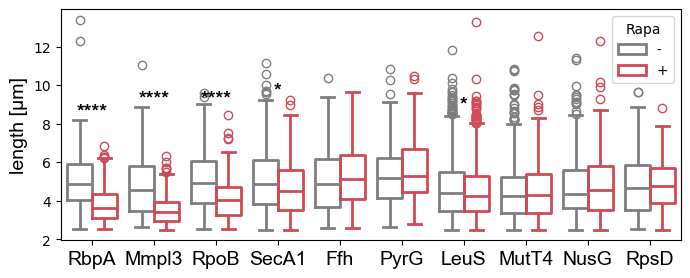

In [185]:
from scipy import stats
f='length [µm]'
sns.set_palette(palette=[np.array([126,126,126])/255,np.array([207,74,84])/255])
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot()
sns.boxplot(data=rec_subset,x='Sample',y=f,hue='Rapa',fill=False,linewidth=2,
               hue_order = ['-','+'],order=['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD'])

for i,s in enumerate(['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']):
    subset=merged[merged['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].values
    rapa_minus = subset[subset['Rapa']=='-'][f].values
    p = stats.mannwhitneyu(rapa_plus,rapa_minus)[1]
    label = ''
    if p<0.0001:
        label = '****'
    elif p<0.001:
        label = '***'
    elif p<0.01:
        label = '**'
    elif p<0.05:
        label = '*'
    ax.text(i,np.percentile(rapa_minus,98),'{}'.format(label),ha='center',va='bottom',weight='bold',
            fontname='Arial',fontsize=14)
ax.set_xticklabels(['RbpA','Mmpl3','RpoB','SecA1','Ffh',
                    'PyrG','LeuS','MutT4','NusG','RpsD'],fontname='Arial',fontsize=14);
ax.set_ylabel(f,fontname='Arial',fontsize=14);
ax.set_xlabel('')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_dist.svg'.format(f),
            bbox_inches='tight',transparent=True)

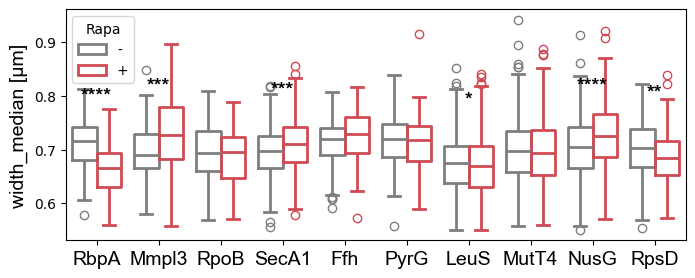

In [20]:
from scipy import stats
f='width_median [µm]'
sns.set_palette(palette=[np.array([126,126,126])/255,np.array([207,74,84])/255])
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot()
sns.boxplot(data=rec_subset,x='Sample',y=f,hue='Rapa',fill=False,linewidth=2,
               hue_order = ['-','+'],order=['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD'])

for i,s in enumerate(['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']):
    subset=merged[merged['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].values
    rapa_minus = subset[subset['Rapa']=='-'][f].values
    p = stats.mannwhitneyu(rapa_plus,rapa_minus)[1]
    label = ''
    if p<0.0001:
        label = '****'
    elif p<0.001:
        label = '***'
    elif p<0.01:
        label = '**'
    elif p<0.05:
        label = '*'
    ax.text(i,np.percentile(rapa_minus,98),'{}'.format(label),ha='center',va='bottom',weight='bold',
            fontname='Arial',fontsize=14)
ax.set_xticklabels(['RbpA','Mmpl3','RpoB','SecA1','Ffh',
                    'PyrG','LeuS','MutT4','NusG','RpsD'],fontname='Arial',fontsize=14);
ax.set_ylabel(f,fontname='Arial',fontsize=14);
ax.set_xlabel('')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_dist.svg'.format(f),
            bbox_inches='tight',transparent=True)

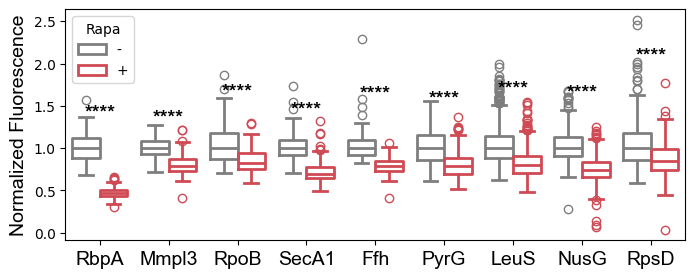

In [186]:
from scipy import stats
f='Normalized Fluorescence'
sns.set_palette(palette=[np.array([126,126,126])/255,np.array([207,74,84])/255])
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot()
sns.boxplot(data=rec_subset,x='Sample',y=f,hue='Rapa',fill=False,linewidth=2,
               hue_order = ['-','+'],order=['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_NusG','REC_RpsD'])

for i,s in enumerate(['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                      'REC_PyrG','REC_LeuS','REC_NusG','REC_RpsD']):
    subset=rec_subset[rec_subset['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].values
    rapa_minus = subset[subset['Rapa']=='-'][f].values
    p = stats.mannwhitneyu(rapa_plus,rapa_minus)[1]
    label = ''
    if p<0.0001:
        label = '****'
    elif p<0.001:
        label = '***'
    elif p<0.01:
        label = '**'
    elif p<0.05:
        label = '*'
    ax.text(i,np.percentile(rapa_minus,98),'{}'.format(label),ha='center',va='bottom',weight='bold',
            fontname='Arial',fontsize=14)
ax.set_xticklabels(['RbpA','Mmpl3','RpoB','SecA1','Ffh',
                    'PyrG','LeuS','NusG','RpsD'],fontname='Arial',fontsize=14);
ax.set_ylabel(f,fontname='Arial',fontsize=14);
ax.set_xlabel('')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_dist.svg'.format(f),
            bbox_inches='tight',transparent=True)

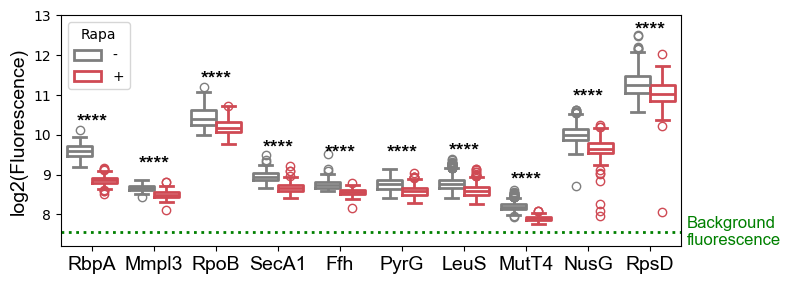

In [191]:
from scipy import stats
f='log2(Fluorescence)'
sns.set_palette(palette=[np.array([126,126,126])/255,np.array([207,74,84])/255])
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot()
sns.boxplot(data=rec_subset,x='Sample',y=f,hue='Rapa',fill=False,linewidth=2,
               hue_order = ['-','+'],order=['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD'])

for i,s in enumerate(['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                      'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']):
    subset=rec_subset[rec_subset['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].values
    rapa_minus = subset[subset['Rapa']=='-'][f].values
    p = stats.mannwhitneyu(rapa_plus,rapa_minus)[1]
    label = ''
    if p<0.0001:
        label = '****'
    elif p<0.001:
        label = '***'
    elif p<0.01:
        label = '**'
    elif p<0.05:
        label = '*'
    ax.text(i,np.percentile(rapa_minus,98)+0.2,'{}'.format(label),ha='center',va='bottom',weight='bold',
            fontname='Arial',fontsize=14)
ax.set_xticklabels(['RbpA','Mmpl3','RpoB','SecA1','Ffh',
                    'PyrG','LeuS','MutT4','NusG','RpsD'],fontname='Arial',fontsize=14);
ax.hlines(y=np.log2(190),xmin=-0.5,xmax=10,color='g',lw=2,ls=':')
ax.text(9.6,np.log2(190),'Background\nfluorescence',fontname='Arial',fontsize=12,
        va='center',ha='left',color='g')
ax.set_xlim(-0.5,9.5)
ax.set_ylim(7.2,13)
ax.set_ylabel(f,fontname='Arial',fontsize=14);
ax.set_xlabel('')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_dist.svg'.format(f),
            bbox_inches='tight',transparent=True)

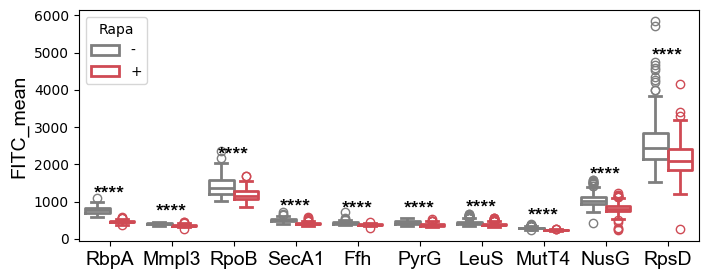

In [31]:
from scipy import stats
f='FITC_mean'
sns.set_palette(palette=[np.array([126,126,126])/255,np.array([207,74,84])/255])
fig=plt.figure(figsize=(8,3))
ax=fig.add_subplot()
sns.boxplot(data=rec_subset,x='Sample',y=f,hue='Rapa',fill=False,linewidth=2,
               hue_order = ['-','+'],order=['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                                            'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD'])

for i,s in enumerate(['REC_RbpA','REC_Mmpl3','REC_RpoB','REC_SecA1','REC_Ffh',
                      'REC_PyrG','REC_LeuS','REC_MutT4','REC_NusG','REC_RpsD']):
    subset=rec_subset[rec_subset['Sample']==s].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].values
    rapa_minus = subset[subset['Rapa']=='-'][f].values
    p = stats.mannwhitneyu(rapa_plus,rapa_minus)[1]
    label = ''
    if p<0.0001:
        label = '****'
    elif p<0.001:
        label = '***'
    elif p<0.01:
        label = '**'
    elif p<0.05:
        label = '*'
    ax.text(i,np.percentile(rapa_minus,98),'{}'.format(label),ha='center',va='bottom',weight='bold',
            fontname='Arial',fontsize=14)
ax.set_xticklabels(['RbpA','Mmpl3','RpoB','SecA1','Ffh',
                    'PyrG','LeuS','MutT4','NusG','RpsD'],fontname='Arial',fontsize=14);
ax.set_ylabel(f,fontname='Arial',fontsize=14);
ax.set_xlabel('')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_{}_dist.svg'.format(f),
            bbox_inches='tight',transparent=True)

In [41]:
ortho_normalized=pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/20231213_ortho_normalized_pred.xlsx').set_index('gene')

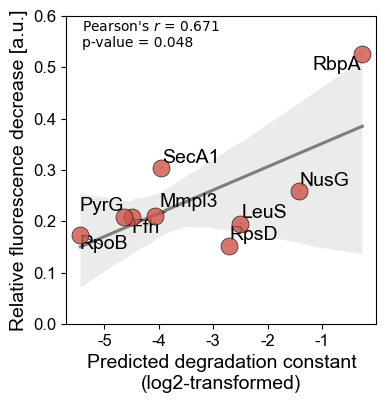

In [194]:
from adjustText import adjust_text as adt
names = ['RbpA','Mmpl3','RpoB','SecA1','Ffh','PyrG','LeuS','NusG','RpsD']
ltags = ['MSMEG_3858','MSMEG_0250','MSMEG_1367','MSMEG_1881','MSMEG_2430','MSMEG_3746',
         'MSMEG_6917','MSMEG_1345','MSMEG_1523']
pred = ortho_normalized.loc[ltags]['Pred'].values
measured_recomb_deg = []

f='FITC_mean'
bg = 190
texts = []
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot()
for i,x in enumerate(names):
    subset=rec_subset[rec_subset['Sample']=='REC_{}'.format(x)].copy()
    rapa_plus = subset[subset['Rapa']=='+'][f].median()
    rapa_minus = subset[subset['Rapa']=='-'][f].median()
    label = ''
    rel_deg = (rapa_minus-rapa_plus)/(rapa_minus-bg)
    measured_recomb_deg.append(rel_deg)
    ax.scatter(pred[i],rel_deg,s=150,ec='black',fc=set(np.array([207,74,84])/255),lw=0.5,alpha=0.8,zorder=5)
    texts.append(ax.text(pred[i],rel_deg,
                         x,
                         fontname='Arial',
                         fontsize=14))
sns.regplot(x=pred,y=measured_recomb_deg,scatter_kws={'color':set(np.array([207,74,84])/255),
                                                      's':0,'ec':'black'},ax=ax)
adt(texts,force_text=(0.5,0.5),s
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
ax.set_ylim(0,0.6)
ax.set_xlabel('Predicted degradation constant\n(log2-transformed)',fontname='Arial',fontsize=14);
ax.set_ylabel('Relative fluorescence decrease [a.u.]',fontname='Arial',fontsize=14);
ax.set_xticklabels([int(x) for x in ax.get_xticks()],fontname='Arial',fontsize=12);
ax.set_yticklabels([round(x,1) for x in ax.get_yticks()],fontname='Arial',fontsize=12);
r,p=stats.pearsonr(pred,measured_recomb_deg)
ax.text(0.05,0.9,"Pearson's $r$ = {}\np-value = {}".format(round(r,3),round(p,3)),transform=ax.transAxes)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240117_microscopy_predict.svg'.format(f),
            bbox_inches='tight',transparent=True)

[0.6026461190226716, 0.08586737139398266]

In [44]:
pred

array([-0.2646125 , -4.07285873, -5.43810318, -3.96536112, -4.48956766,
       -4.6310523 , -2.50264137, -0.4889835 , -1.4270356 , -2.71835982])